# PREOPS-630-diffim-sprint-recproc

## Diagnostic plots of the 2021 diffimg sprint datasets reprocessed with w_36 and having the recommended setting for each iteration
## The templates are also new, generated with w_36

In [1]:

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import importlib
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u
from types import SimpleNamespace
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)

import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display as afw_display
afwDisplay.setDefaultBackend('matplotlib')
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.pipe.base import Struct

import IPython
from IPython.display import IFrame

In [2]:
#sys.path.append('/project/mrawls/ap_pipe-notebooks/')
sys.path.append('/project/kherner/PREOPS-598_reprocSprint/ap_pipe-notebooks/')

In [3]:
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa

In [4]:
#repo = '/datasets/hsc/gen3repo/rc2w50_ssw02'
repo = '/repo/main'
butler = dafButler.Butler(repo)

In [5]:
default_best = SimpleNamespace(collection = 'u/kherner/PREOPS-630_w36_default_bestSeeing_20210929',
                               apdb = 'lsstdevapdb1',
                               schema = 'kherner_PREOPS_630_default_best_w36_20210929',
                              selname = 'bestThird')
preconvolve_best = SimpleNamespace(collection = 'u/kherner/PREOPS-630_w36_default_bestSeeing_Preconvolve_20210929',
                                   apdb = 'lsstdevapdb1',
                                   schema = 'kherner_PREOPS_630_default_best_Preconvolve_w36_20210929',
                                  selname = 'bestThird')
default_middle = SimpleNamespace(collection = 'u/kherner/PREOPS-630_w36_default_middleSeeing_20210915',
                                 apdb = 'lsstdevapdb1',
                                 schema = 'kherner_PREOPS_630_default_middle_w36_20210915',
                                selname = 'middleSeeing')
convolvesci_middle = SimpleNamespace(collection = 'u/kherner/PREOPS-630_w36_middleSeeing_convolveSci_20210915',
                                     apdb = 'lsstdevapdb1',
                                     schema = 'kherner_PREOPS_630_middle_convolveSci_w36_20210915',
                                    selname = 'middleSeeing')


In [6]:

apdbs_nonempty = [default_best, preconvolve_best, default_middle, convolvesci_middle]

badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

print(f'N DiaSources and N "good" DiaSources in each collection')
print(f'-------------------------------------------------------')
for run in apdbs_nonempty:
    collection = run.collection
    apdb = run.apdb
    schema = run.schema
    objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName=apdb,
                                                          gen='gen3',
                                                          schema=schema,
                                                          instrument='HSC',
                                                          badFlagList=badFlagList)
    print(f'{len(srcTable):7d}\t{len(goodSrc):7d}\t\t{collection.split("/")[-1]}')

N DiaSources and N "good" DiaSources in each collection
-------------------------------------------------------


  78775	  16638		PREOPS-630_w36_default_bestSeeing_20210929
  82471	  17954		PREOPS-630_w36_default_bestSeeing_Preconvolve_20210929
  78671	  17640		PREOPS-630_w36_default_middleSeeing_20210915
 143985	  73940		PREOPS-630_w36_middleSeeing_convolveSci_20210915


In [7]:
oneVisit = 1220
oneDetector = 66

collection_list = [default_best,
                   preconvolve_best,
                   default_middle,
                   convolvesci_middle]

In [8]:
# Mostly for debugging only
dataId = {"band": "g", "skymap": "hsc_rings_v1", "tract":9813}

for ipatch in range(33, 60):
#    print( 'Patch %s' % ipatch)
    for collections in [ default_best, default_middle ]:
        collname = collections.selname+'Coadd.coaddInputs'
#        print(collname)
#        print('--- ' + collections.selname + ' ---')
        try:
            coaInput = butler.get(collname, instrument='HSC',
                          dataId=dataId, collections=collections.collection, patch=ipatch)
            #print(coaInput.visits.get('id'))
            #print(coaInput.ccds.columns)
        except:
            print('Unable to get patch %d' % ipatch)

In [9]:
sigma2fwhm = 2.*np.sqrt(2.*np.log(2.))

def getFWHM(collections, patch, band):
    dataId = {"band": band, "skymap": "hsc_rings_v1", "tract":9813}
    collname = collections.selname+'Coadd'
    try:
        psf = butler.get(collname, instrument='HSC', component='psf',
                          dataId=dataId, collections=collections.collection, patch=patch).getPsf()
        fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm
    except:
        print("Unable to calculate psf for {}, patch {}".format(collname, patch))
        fwhm = 0
    return fwhm

Print the seeing for every tenth patch for both the best and middle third templates.
Change at your discretion.

In [10]:
print("Patch | Best third FWHM g | Mid third FWHM g || Best third FWHM r | Mid third FWHM r")
print("----------------------------------------")
for ipatch in range(1, 60, 10):
    bestfwhmg = getFWHM(default_best, ipatch, 'g')
    midfwhmg = getFWHM(default_middle, ipatch, 'g')
    bestfwhmr = getFWHM(default_best, ipatch, 'r')
    midfwhmr = getFWHM(default_middle, ipatch, 'r')
    print("{0:02d}    | {1:.10f}      | {2:.10f}     || {3:.10f}      | {4:.10f}".format(
        ipatch, bestfwhmg, midfwhmg, bestfwhmr, midfwhmr))

Patch | Best third FWHM g | Mid third FWHM g || Best third FWHM r | Mid third FWHM r
----------------------------------------


/tmp/ipykernel_3591/3086071131.py:9: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  fwhm = psf.computeShape().getDeterminantRadius()*sigma2fwhm


Unable to calculate psf for bestThirdCoadd, patch 1
01    | 4.6752540776      | 4.7995313252     || 0.0000000000      | 3.3181888478
11    | 4.6147397276      | 5.0754816006     || 3.0058443241      | 3.3234940864
21    | 4.4514292057      | 4.8853924425     || 2.8887557729      | 3.1952752063
31    | 4.4130211364      | 4.7970856352     || 2.8747361423      | 3.2351848755
41    | 4.3971071439      | 4.8108635200     || 2.8817372860      | 3.1834162938
51    | 4.4634331420      | 4.8645504747     || 2.9514283324      | 3.2374230066


diffim variance median
----------------------
425.938538	PREOPS-630_w36_default_bestSeeing_20210929
446.386200	PREOPS-630_w36_default_bestSeeing_Preconvolve_20210929
707.583313	PREOPS-630_w36_default_middleSeeing_20210915
633.143066	PREOPS-630_w36_middleSeeing_convolveSci_20210915


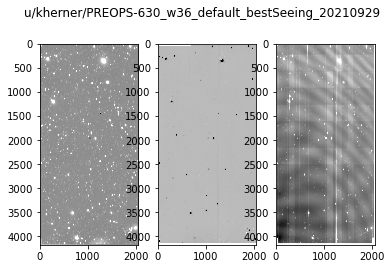

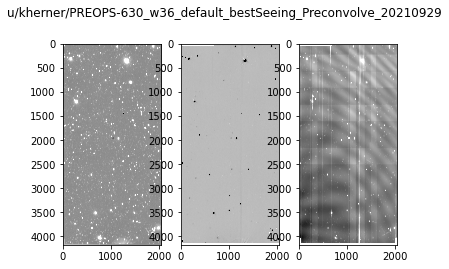

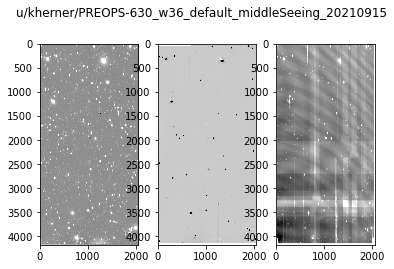

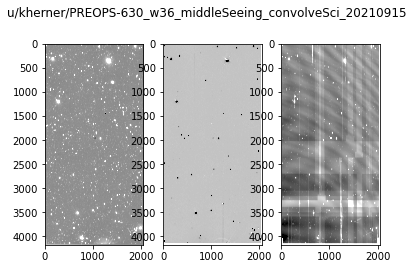

In [11]:
print(f'diffim variance median')
print(f'----------------------')
for collections in collection_list:
#for collections in [default_best.collection, preconvolve_best.collection]:
    calexp = butler.get('calexp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections.collection)
    diffim = butler.get(collections.selname+'Diff_differenceExp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections.collection)

    calexpNorm = ImageNormalize(calexp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimNorm = ImageNormalize(diffim.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimVarNorm = ImageNormalize(diffim.variance.array, interval=ZScaleInterval(), stretch=SqrtStretch())

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle(collections.collection)
    ax1.imshow(calexp.image.array, cmap='gray', norm=calexpNorm)
    ax2.imshow(diffim.image.array, cmap='gray', norm=diffimNorm)
    ax3.imshow(diffim.variance.array, cmap='gray', norm=diffimVarNorm)
    
    print(f'{np.median(diffim.variance.array):8f}\t{(collections.collection).split("/")[-1]}')

## Make key plots for all the runs


Here, I'll construct `run_list` to showcase ones with best-seeing templates by default, and showcase ones with worst-seeing templates in the case differencing was run with preconvolution **or** science image convolution (instead of template convolution).

In [12]:
def makeplots(run):
    collection = run.collection
    apdb = run.apdb
    schema=run.schema
    print(collection, apdb)
    dbPath = apdb
    objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName=dbPath,
                                                          schema=schema,
                                                          gen='gen3',
                                                          instrument='HSC')
    srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument='HSC', gen='gen3', butler=butler)
    flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                                   badFlagList=badFlagList,
                                                                                   gen='gen3', instrument='HSC',
                                                                                   repo=repo)
    # Good DIA Sources
    fig = plt.figure(figsize=(4,4))
    xlim = (150.45, 149.8)
    ylim = (2.1, 2.5)
    ax = fig.add_subplot(111)
    plt.setp(ax, xlim=xlim, ylim=ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.scatter(goodSrc['ra'], goodSrc['decl'], c='C0', s=0.1, marker='o', alpha=0.4)
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.set_title(f'DIA Sources ({str(collection).split("/")[-1]})')
    
    # Good DIA Sources by visit
    bandList = ['g', 'r']
    colorList = ['C2', 'C1']
    for band, color in zip(bandList, colorList):
        pla.plotDiaSourcesOnSkyGrid(repo, goodSrc.loc[goodSrc['filterName'] == band],
                                    title=band+' band', color=color, size=5)
    
    # How many DIA Sources comprise each DIA Object
    hist = doa.plotDiaObjectHistogram(objTable, goodObj)
    
    # Flag bar chart
    pla.plotFlagHist(srcTable, badFlagList=badFlagList)
    
    # Flux distributions
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'g'], fluxType='psFlux',
                        title='DIA Sources, HSC-G, Diffim PSF Flux', color1='C2', binmin=-1e3, binmax=1e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'r'], fluxType='psFlux',
                        title='DIA Sources, HSC-R, Diffim PSF Flux', color1='C1', binmin=-1e3, binmax=1e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'g'], fluxType='totFlux',
                        title='DIA Sources, HSC-G, Calexp PSF Flux', color1='C2', binmin=-1e3, binmax=2e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'r'], fluxType='totFlux',
                        title='DIA Sources, HSC-R2, Calexp PSF Flux', color1='C1', binmin=-1e3, binmax=2e3)
    
    # Flux histograms
    pla.source_magnitude_histogram(repo, goodSrc, 'g', 'HSC', collection)
    pla.source_magnitude_histogram(repo, goodSrc, 'r', 'HSC', collection)
    
    # A few cutouts
    for index, source in goodSrc[:4].iterrows():
        dataId = {'detector': int(goodSrc['ccd'][index]), 'visit': int(goodSrc['visit'][index]), 'instrument': 'HSC'}
        center = lsst.geom.SpherePoint(goodSrc['ra'][index], goodSrc['decl'][index], lsst.geom.degrees)
        scienceCutout, differenceCutout, templateCutout = plc.retrieveCutouts(butler, dataId, collection, center, diffName=run.selname)
        plc.plotCutout(scienceCutout, differenceCutout, templateCutout)

In [13]:
run_list = [default_best, default_middle, convolvesci_middle, preconvolve_best]

### Plots for defaults, best third seeing templates

u/kherner/PREOPS-630_w36_default_bestSeeing_20210929 lsstdevapdb1


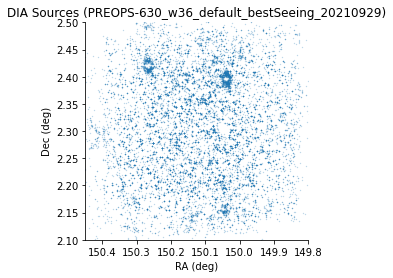

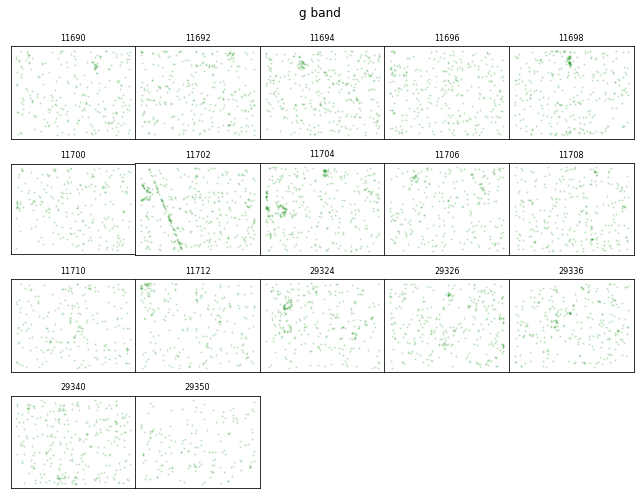

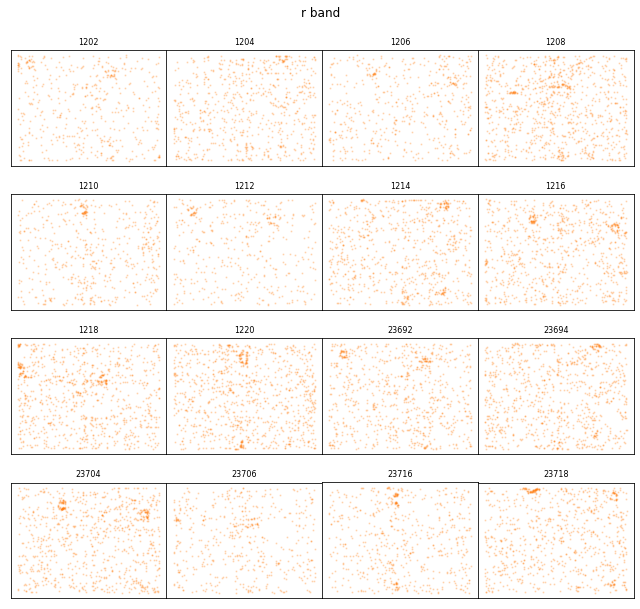

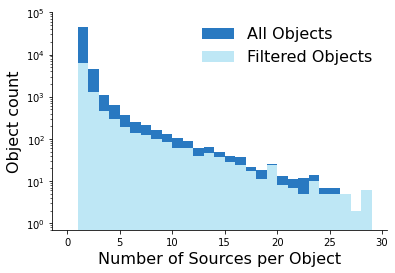

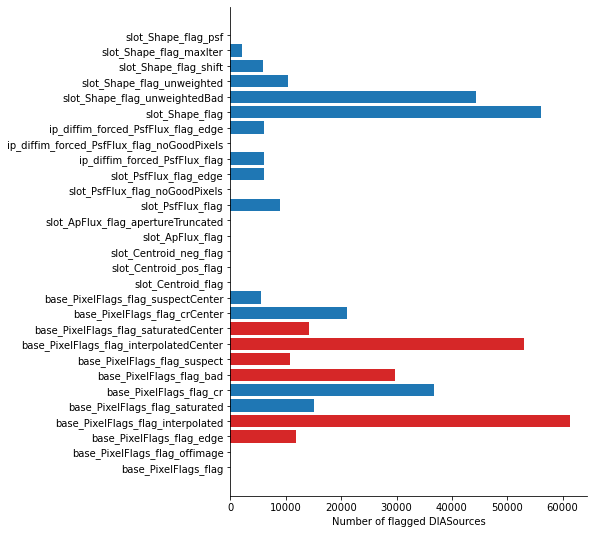

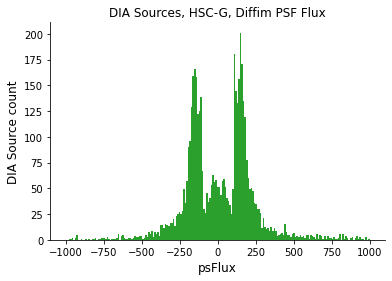

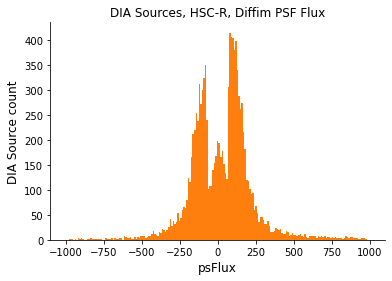

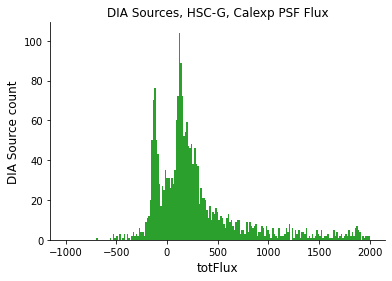

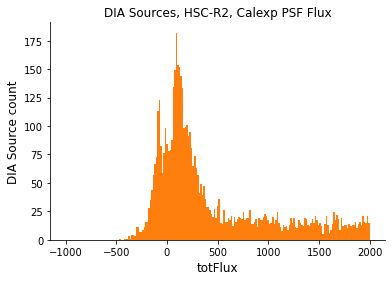

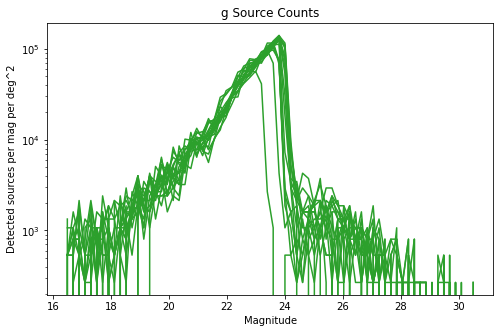

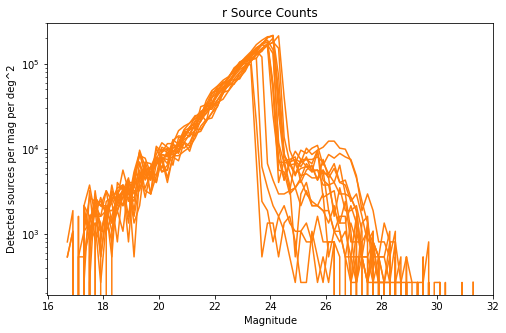

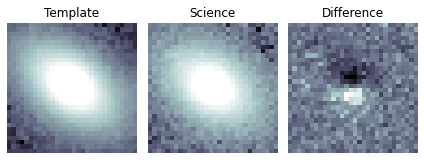

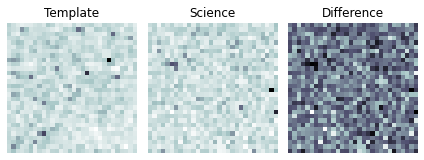

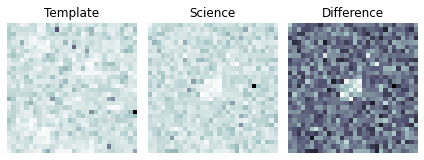

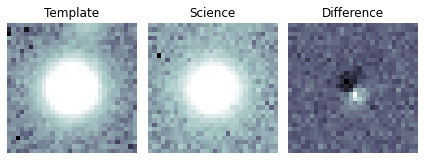

In [14]:
makeplots(default_best)

### Plots for preconvolution, best third seeing templates

u/kherner/PREOPS-630_w36_default_bestSeeing_Preconvolve_20210929 lsstdevapdb1


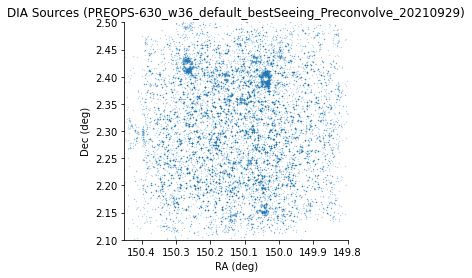

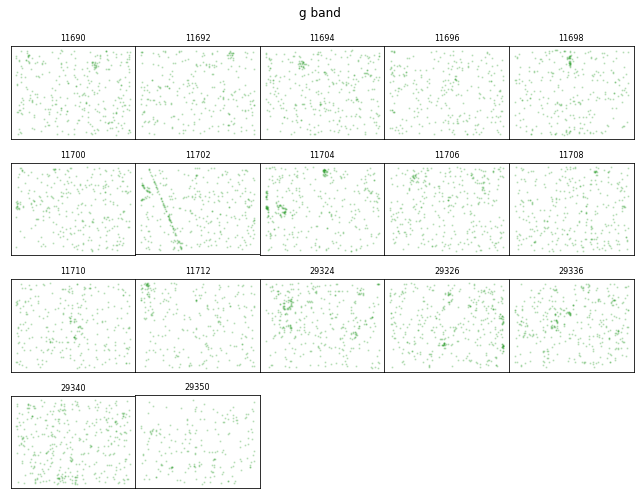

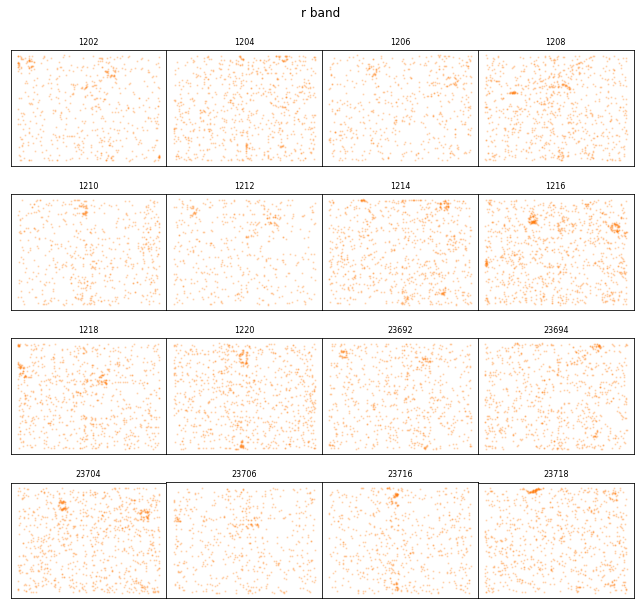

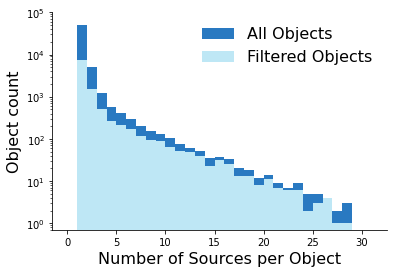

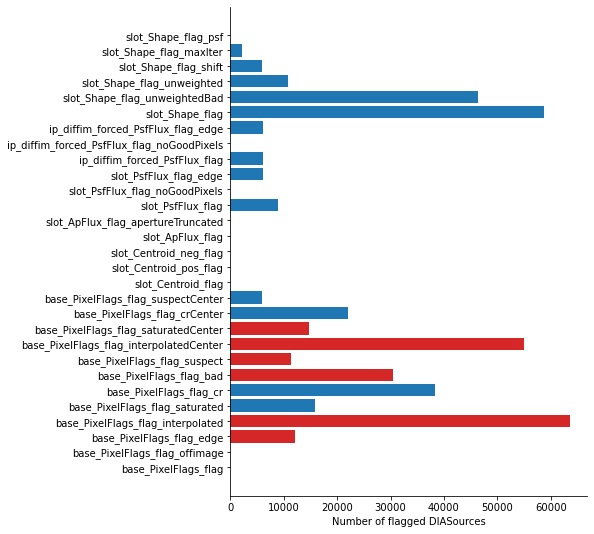

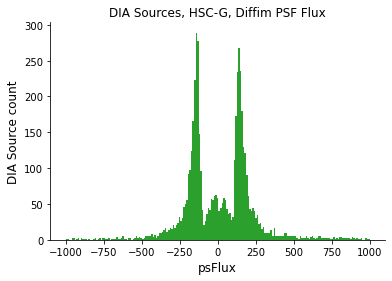

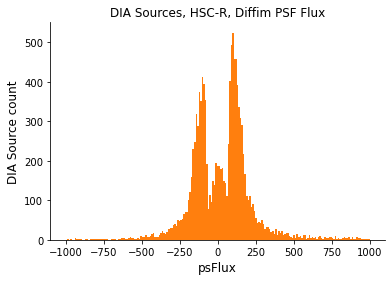

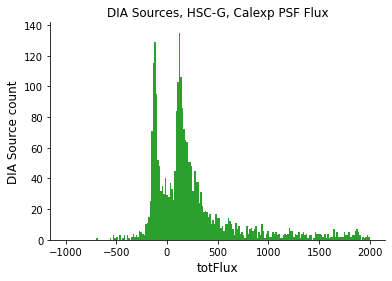

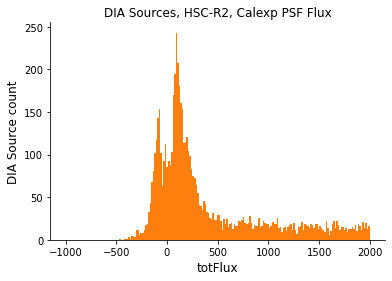

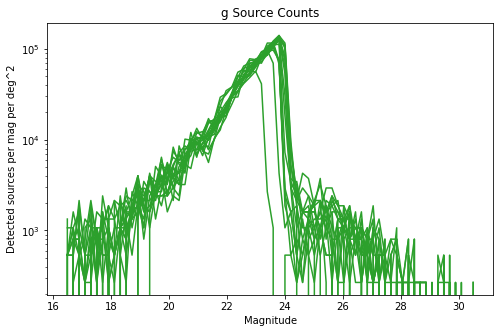

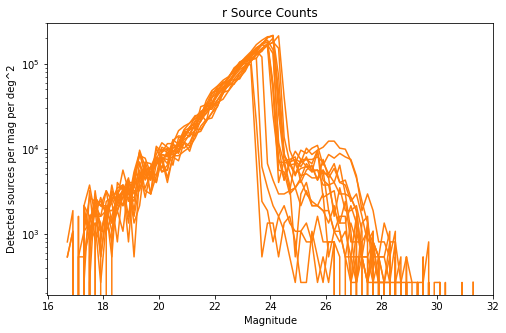

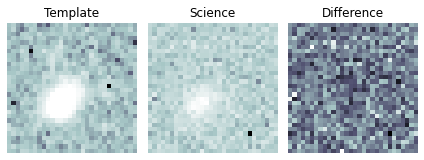

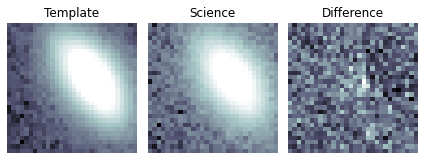

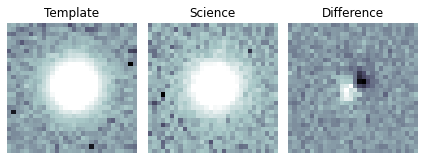

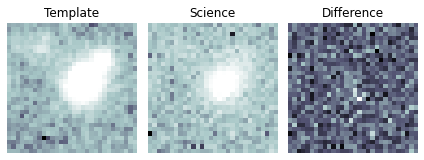

In [15]:
makeplots(preconvolve_best)

### Plots for defaults, middle third seeing templates

u/kherner/PREOPS-630_w36_default_middleSeeing_20210915 lsstdevapdb1


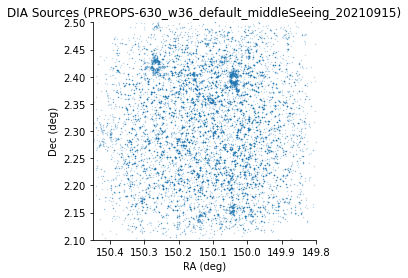

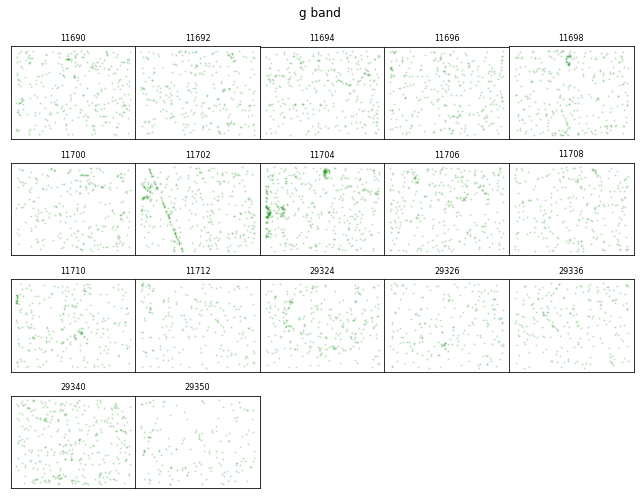

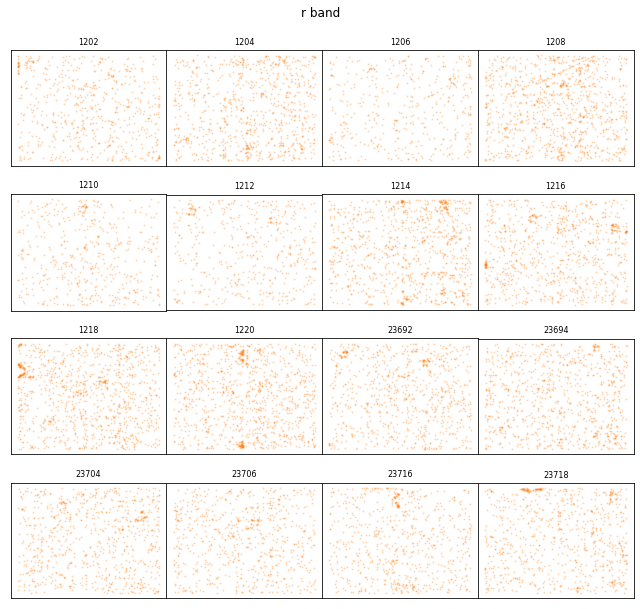

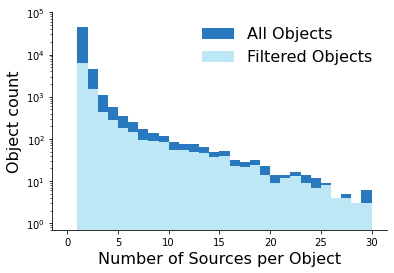

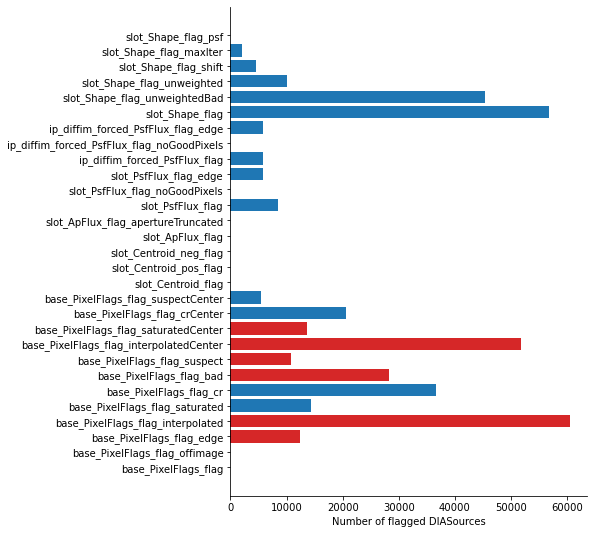

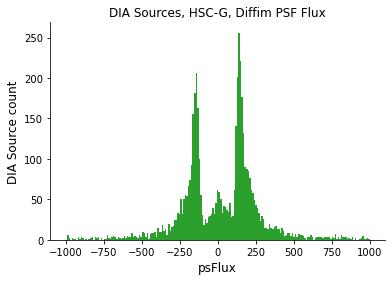

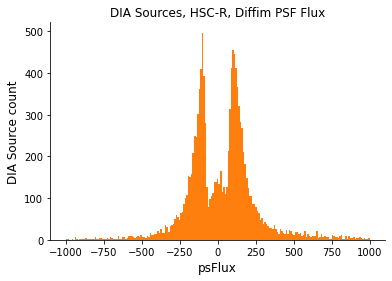

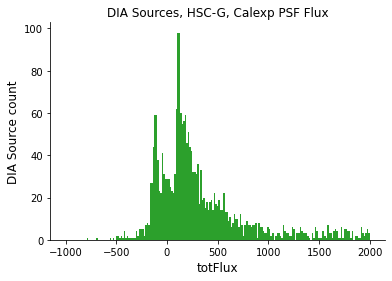

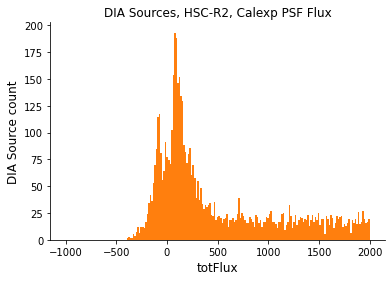

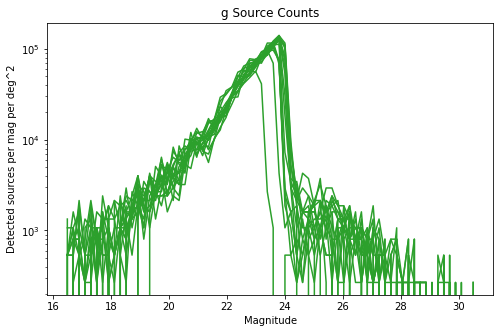

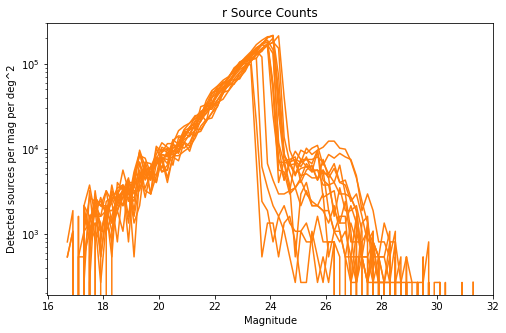

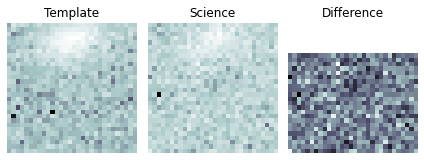

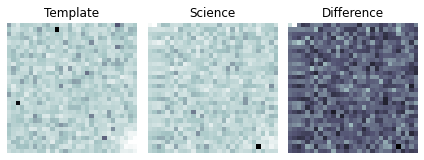

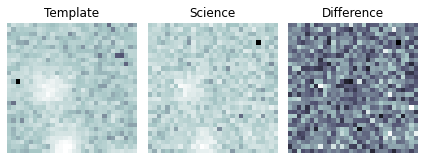

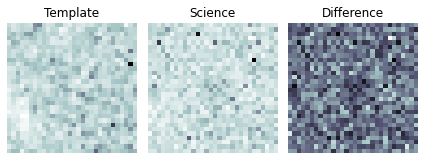

In [16]:
makeplots(default_middle)

### Plots for convolving science image, middle third seeing templates

u/kherner/PREOPS-630_w36_middleSeeing_convolveSci_20210915 lsstdevapdb1


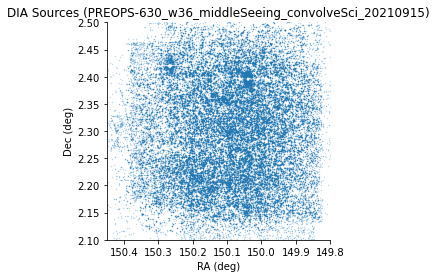

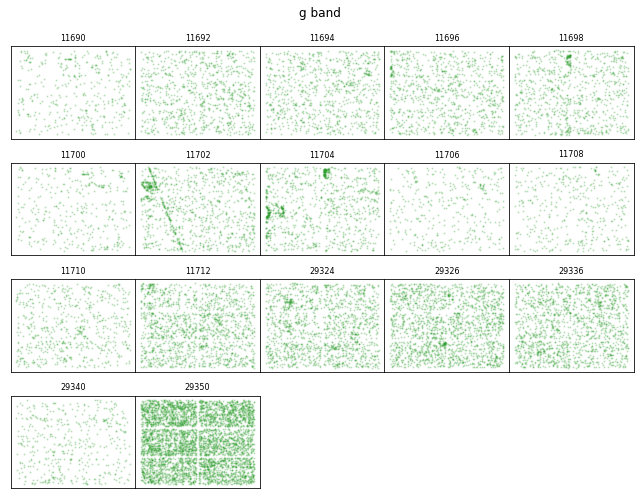

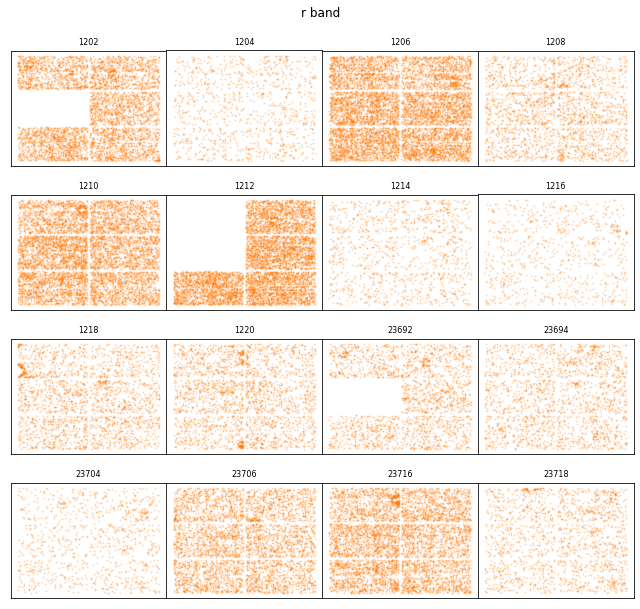

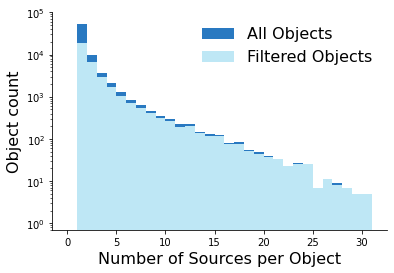

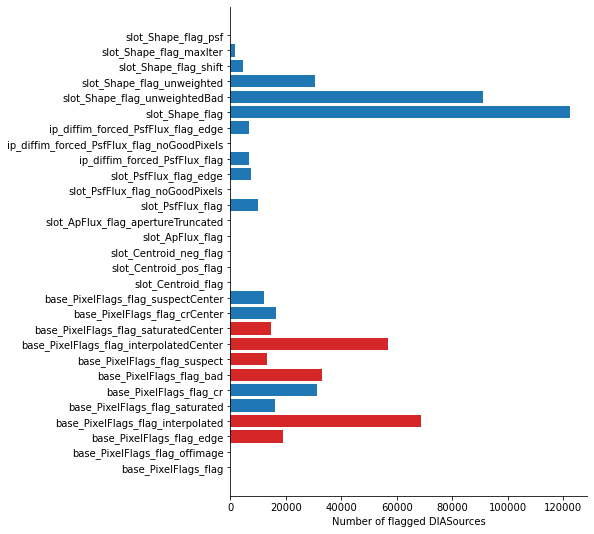

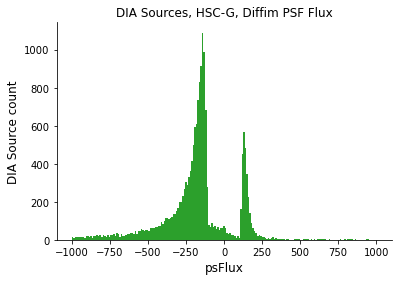

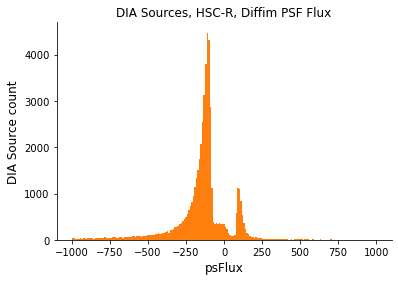

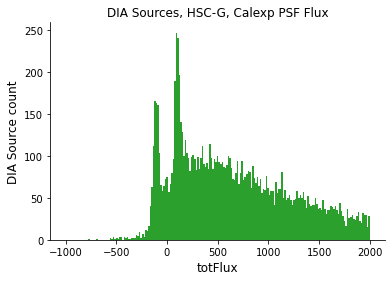

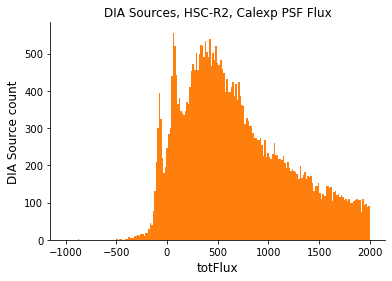

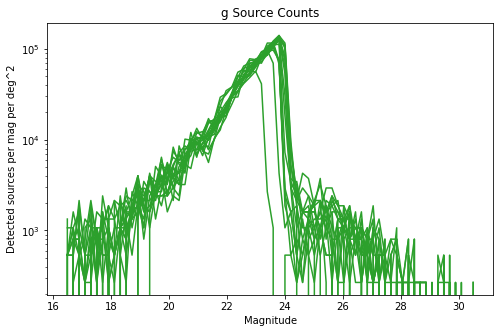

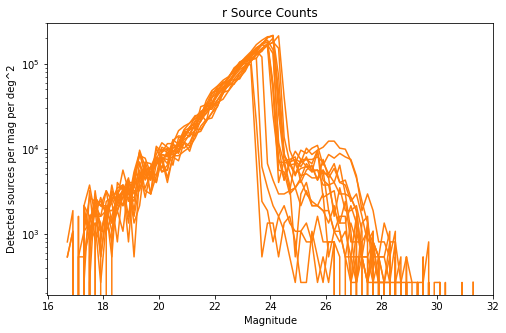

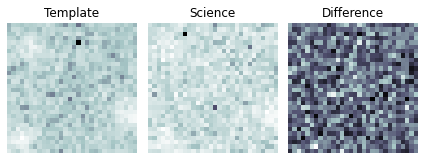

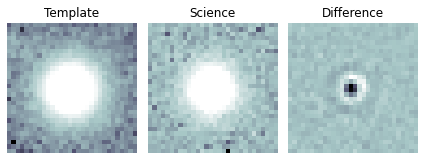

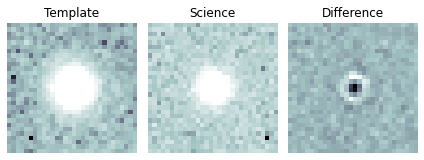

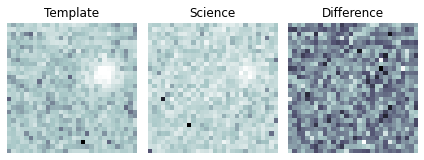

In [17]:
makeplots(convolvesci_middle)